# Retrieval Augmented Generation evaluation

### LOADING

#### Load Embedings

In [1]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load dataset
task_prompts_df = pd.read_csv('dataset/task_prompts.csv')
nodes_df = pd.read_csv('dataset/nodes.csv')

print("Task prompts:", task_prompts_df.shape)
print("Nodes:", nodes_df.shape)

# Load embedings
task_prompt_embedings = np.load('dataset/task_prompts_embeddings.npy')
nodes_texts_embedings = np.load('dataset/nodes_texts_embeddings.npy')

print("Task prompts embedings:", task_prompt_embedings.shape)
print("Nodes texts embedings:", nodes_texts_embedings.shape)

# Prepare model
model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

/home/vicentamen/miniconda3/envs/py38/lib/python3.8/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-10-14 09:06:37.910808: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 09:06:38.035476: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-14 09:06:38.650833: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, 

Task prompts: (1, 2)
Nodes: (2076, 7)
Task prompts embedings: (1, 768)
Nodes texts embedings: (2076, 768)


/home/vicentamen/miniconda3/envs/py38/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


### EVALUATE TASKS

In [2]:
# Get the nodes indexes for a given task_id
def get_nodes_indexes(task_id, nodes_df):
    return nodes_df[nodes_df['task_id'] == task_id].index


def get_nodes_embeddigs(nodes_indexes, nodes_texts_embedings):
    return nodes_texts_embedings[nodes_indexes]


def get_task_embedings(task_index, task_prompt_embedings):
    # Get the task prompt embedings
    task_embedints = task_prompt_embedings[task_index]    
    return task_embedints

def get_top_nodes(similarities, k=10):
    import tensorflow as tf
    # Get top k nodes
    top_values, indices = tf.math.top_k(similarities, k)
    return top_values.numpy().flatten(), indices.numpy().flatten()

# Proportion  of positive candidates in the relevant nodes
def calculate_precision(relevant_nodes):
    # Check how many of the selected relevant nodes are set as pos_candidates
    total = len(relevant_nodes)
    # Count the number of positive candidates to the k-th element
    pos_candidates_count = len(relevant_nodes[relevant_nodes['pos_candidate'] == 1])
    pos_candidates_k1_count = len(relevant_nodes[relevant_nodes['pos_candidate_k1'] == 1])
    pos_candidates_k3_count = len(relevant_nodes[relevant_nodes['pos_candidate_k3'] == 1])
    pos_candidates_k5_count = len(relevant_nodes[relevant_nodes['pos_candidate_k5'] == 1])
    
    return {'k0 precision: ': pos_candidates_count / total, 
            'k1 precision: ': pos_candidates_k1_count / total, 
            'k3 precision: ': pos_candidates_k3_count / total, 
            'k5 precision: ': pos_candidates_k5_count / total}

def evaluate_task(task, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model, k=10):
    """
    This function evaluates a task by calculating the precision of the top 10 nodes for all the actions recorded for the task.
    If we wanted to evaluate the model for a single action, we could use the function evaluate_action.
    """
    task_id = task['task_id']
    task_index = task_prompts_df[task_prompts_df['task_id'] == task_id].index[0]
    k0_candidates_count = len(nodes_df[(nodes_df['task_id'] == task_id) & (nodes_df['pos_candidate'] == 1)])
    k1_candidates_count = len(nodes_df[(nodes_df['task_id'] == task_id) & (nodes_df['pos_candidate_k1'] == 1)])
    k3_candidates_count = len(nodes_df[(nodes_df['task_id'] == task_id) & (nodes_df['pos_candidate_k3'] == 1)])
    k5_candidates_count = len(nodes_df[(nodes_df['task_id'] == task_id) & (nodes_df['pos_candidate_k5'] == 1)])
    
    # The specific task prompt embeddings
    prompt_embedings = get_task_embedings(task_index, task_prompt_embedings)
    
    # Get the nodes embeddings
    nodes_indexes = get_nodes_indexes(task_id, nodes_df)
    nodes_embedings = get_nodes_embeddigs(nodes_indexes, nodes_texts_embedings)
    
    # Calculate the similarity
    similarities = model.similarity(prompt_embedings, nodes_embedings)
    
    # Get the top 10 nodes
    top_values, top_nodes_indices = get_top_nodes(similarities, k)
    
    # Convert nodes_indexes to a numpy array and use it for indexing
    nodes_indexes_array = np.array(nodes_indexes)
    top_nodes_indexes = nodes_indexes_array[top_nodes_indices]
    
    # Use integer indexing to get the correct nodes
    top_nodes = nodes_df.loc[top_nodes_indexes]
    
    # Calculate the task precision
    precision = calculate_precision(top_nodes)
    
    return top_nodes, precision

In [3]:
# Test task evaluation
test_task = task_prompts_df.iloc[0]
print("Task:", test_task)

top_nodes, results = evaluate_task(test_task, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model, 100)
print("Task precision: ", results)

Task: task_id                 7bda9645-0b5f-470a-8dd7-6af0bff4da68
prompt     Check for pickup restaurant available in Bosto...
Name: 0, dtype: object
Task precision:  {'k0 precision: ': 0.0, 'k1 precision: ': 0.01, 'k3 precision: ': 0.07, 'k5 precision: ': 0.18}


2024-10-14 09:06:50.202574: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
print(len(top_nodes))

100


In [6]:
import pandas as pd
from tqdm import tqdm

# Evaluate all tasks
results = []
total_tasks = len(task_prompts_df)
for index, row in tqdm(task_prompts_df.iterrows(), total=total_tasks):
    top_nodes, task_precision = evaluate_task(row, nodes_df, task_prompts_df, task_prompt_embedings, nodes_texts_embedings, model)
    results.append({'task_id': row['task_id'], 'precision': task_precision})
    
print('Tasks evaluated: ', len(results))

100%|██████████| 1/1 [00:00<00:00, 95.07it/s]

Tasks evaluated:  1


### RESULTS EVALUATION

In [7]:
print(results)

[{'task_id': '7bda9645-0b5f-470a-8dd7-6af0bff4da68', 'precision': {'k0 precision: ': 0.0, 'k1 precision: ': 0.1, 'k3 precision: ': 0.2, 'k5 precision: ': 0.6}}]


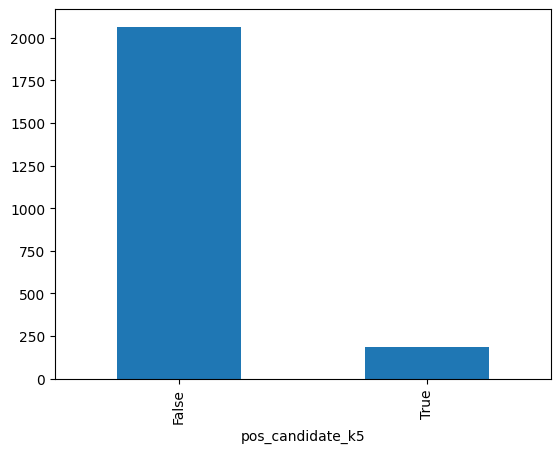